## Import modules

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from statistics import mean
from matplotlib.backends.backend_pdf import PdfPages

## Select the spot intensity analysis file to open

In [18]:
# Should be a spot analysis.csv file, derived from the Spot Intensity Analysis plugin in Fiji
path = input("Enter the path to the spot analysis.csv from Fiji: ")
output_filename = input("Specify the output filename you would like: ")

raw_df = pd.read_csv(path)
desktop_path = "/Users/steinar/Desktop/"

Enter the path to the spot analysis.csv from Fiji: /Users/steinar/Documents/Data/4 - cell vs. endosomal membrane in fusion/figures and data for publishing/fig. 3 - coverage, trace types and PMV vs. liposome lipid and content mixing/2024-08 liposomes + 30mM Calcein 8x fFT cycles content mixing/spot analysis files/Spot analysis of IAV+BMPliposome3_MMStack_Pos0.csv
Specify the output filename you would like: IAV + BMP liposome 3


## Remove all frames before the pH drop and specify time per frame

In [19]:
# specify the frame where fusion was triggered (pH drop)
pH_drop_frame = 16

# specify seconds per frame
sec_per_frame = 0.50

# drops all columns before fusion was triggered + the x and y coordinates column
df = raw_df.iloc[:, (pH_drop_frame-1+2):]
df.columns = [(i * sec_per_frame) for i in range(len(df.columns))]
df.columns = df.columns.astype(float)

## _Optional: Average out focus events_

In [27]:
# Fill in the time before and after a focusing event. 
# All values in the frames between will be replaced by the average of these two frames
time_before_focus_event = 1
time_after_focus_event = 2

for particle, time in df.iterrows():
    avg = time[[time_before_focus_event, time_after_focus_event]].mean()
    df.loc[particle, time_before_focus_event:time_after_focus_event] = avg

/var/folders/y_/y3x4g2n90qjd66186gkmgdvc0000gn/T/ipykernel_50481/3091287139.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[particle, time_before_focus_event:time_after_focus_event] = avg
/var/folders/y_/y3x4g2n90qjd66186gkmgdvc0000gn/T/ipykernel_50481/3091287139.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[particle, time_before_focus_event:time_after_focus_event] = avg


#  Fusion event analysis

In [20]:
# set the threshold intensity increase for a potential fusion event
event_threshold = 3000

events = {}
intensity_increase = {}
frames = list(df.columns)

# Iterate through each particle (row)
for particle, time in df.iterrows():
    potential_events = []
    # Iterate through each frame (column)
    for i in range(1, len(frames)):
        current_frame = frames[i]
        previous_frame = frames[i - 1]
        # Calculate the intensity difference between the current frame and the previous frame
        difference = time[current_frame] - time[previous_frame]
        # Check if the difference exceeds the event threshold
        if difference > event_threshold:
            potential_events.append((current_frame, difference))

    # Sort potential events by frame index
    potential_events.sort(key=lambda x: frames.index(x[0]))

    filtered_events = []
    max_difference = -float('inf')
    max_frame = None

    # Filter the potential events to only include the frame with the highest difference within ±10 frames
    for i in range(len(potential_events)):
        current_frame, difference = potential_events[i]
        if max_frame is None or frames.index(current_frame) > frames.index(max_frame) + 10:
            if max_frame is not None:
                filtered_events.append(max_frame)
            max_difference = difference
            max_frame = current_frame
        elif difference > max_difference:
            max_difference = difference
            max_frame = current_frame

    if max_frame is not None:
        filtered_events.append(max_frame)

    if filtered_events:
        events[particle] = filtered_events
        intensity_increase[particle] = [time[frame] - time[frames[frames.index(frame) - 1]] for frame in filtered_events]

## Print list of all event times and manually remove recurring events
If many events occur at the same time point, it may be a focusing event

In [28]:
# fill in the list with the time points you want to remove events from
remove_events = []

events = {key: [value for value in values if value not in remove_events] for key, values in events.items()}
events = {key: values for key, values in events.items() if len(values) > 0}

print("waiting times for detected events:")
for event_times in sorted(list(events.values())):
    print(event_times)

waiting times for detected events:
[1.0]
[2.0]
[2.5]
[4.0]
[4.5]
[7.5]
[11.0]
[14.5]
[15.5]
[25.0]
[48.0]
[63.0]
[76.5]
[99.0]
[113.5]
[270.5]


## Plots the intensity profile of each particle with a detected event
Also saves all plots to the desktop as a .pdf report

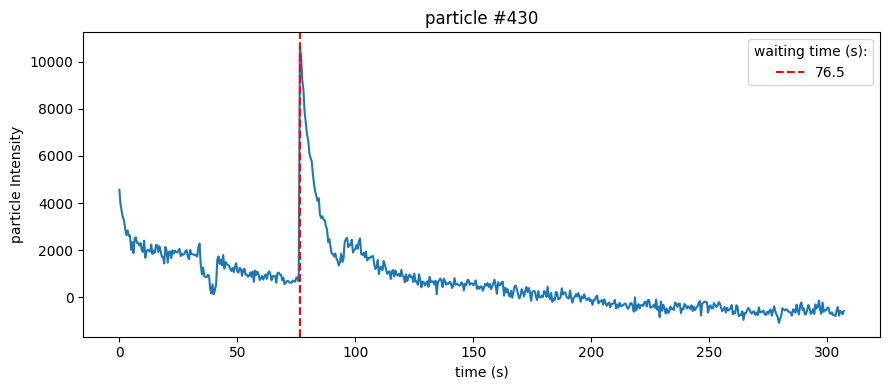

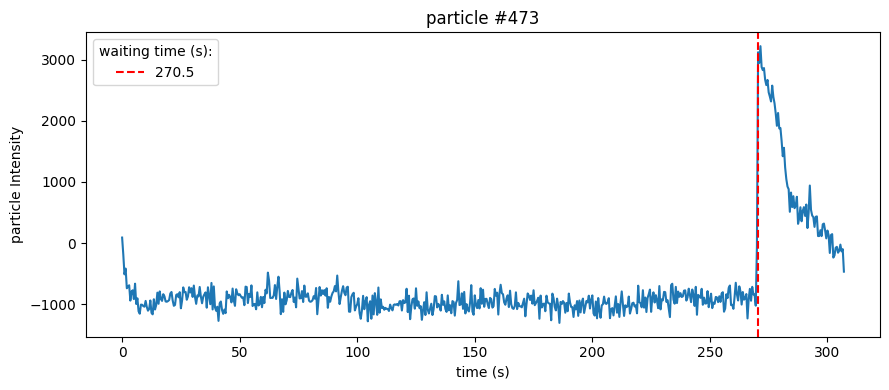

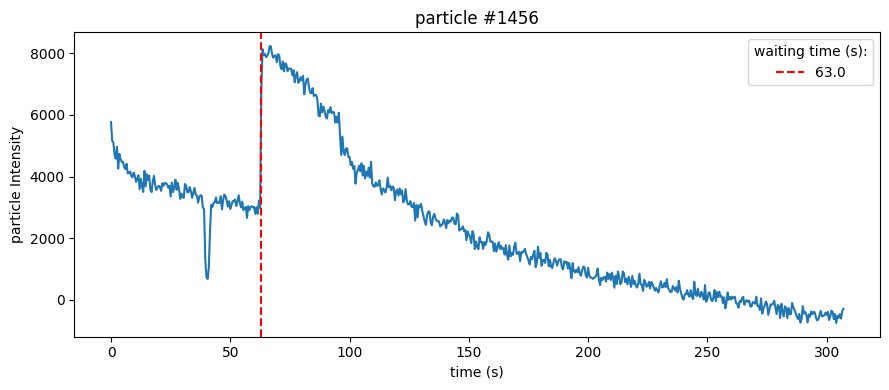

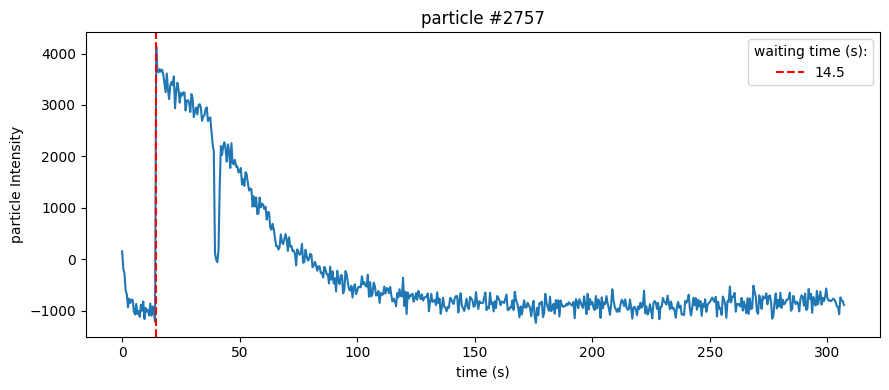

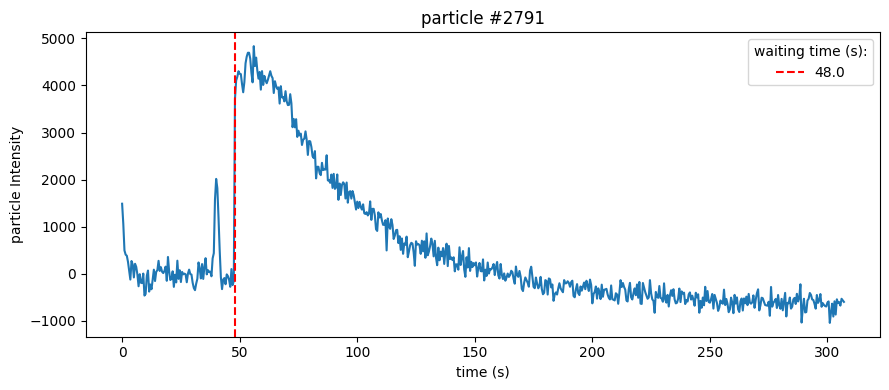

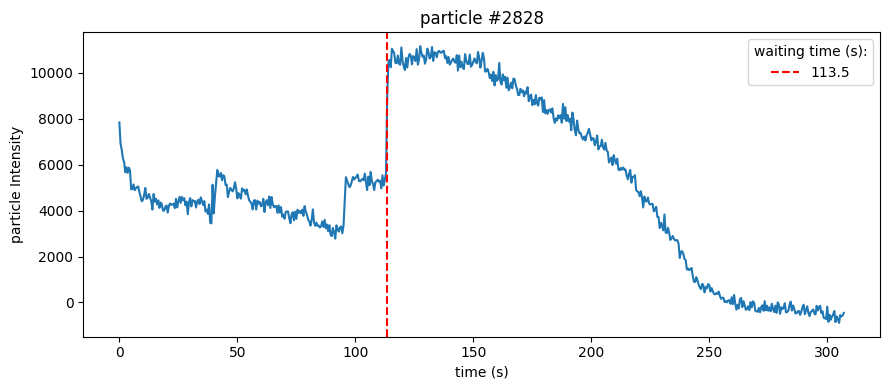

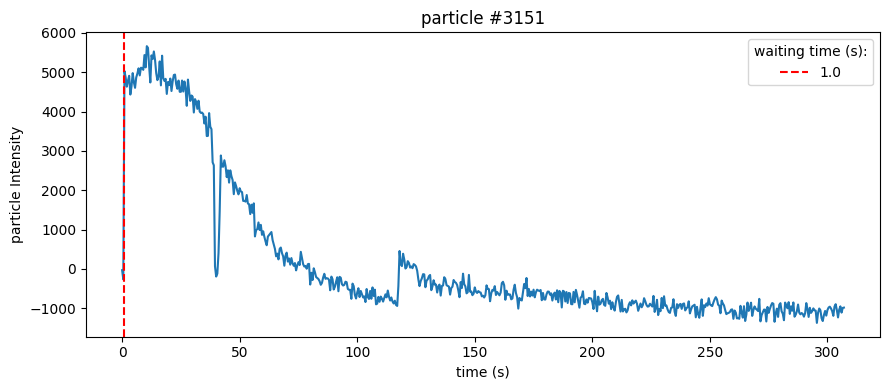

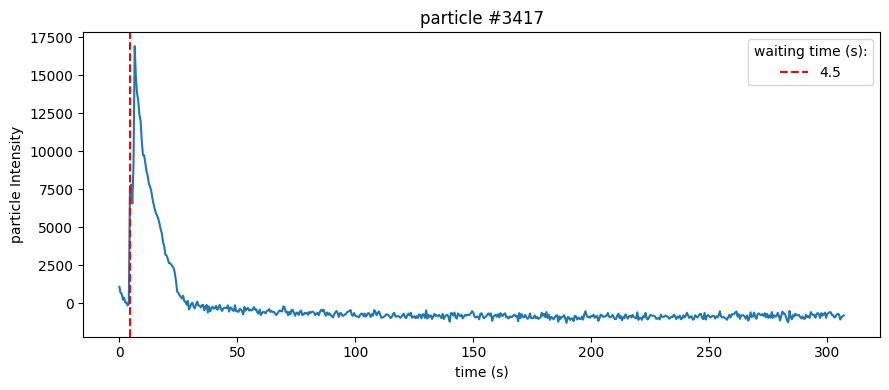

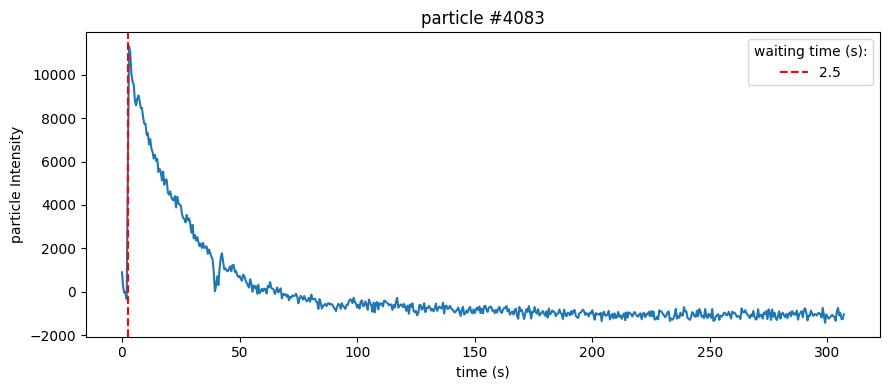

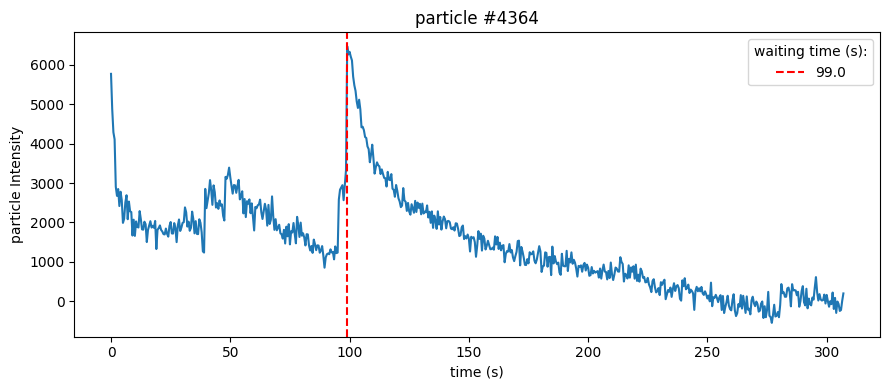

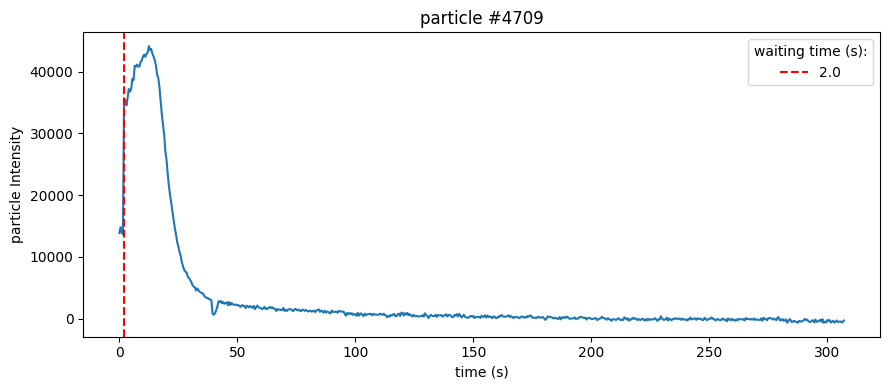

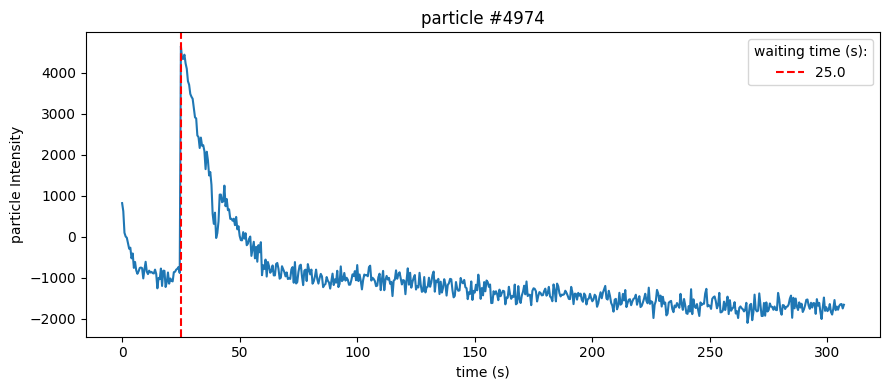

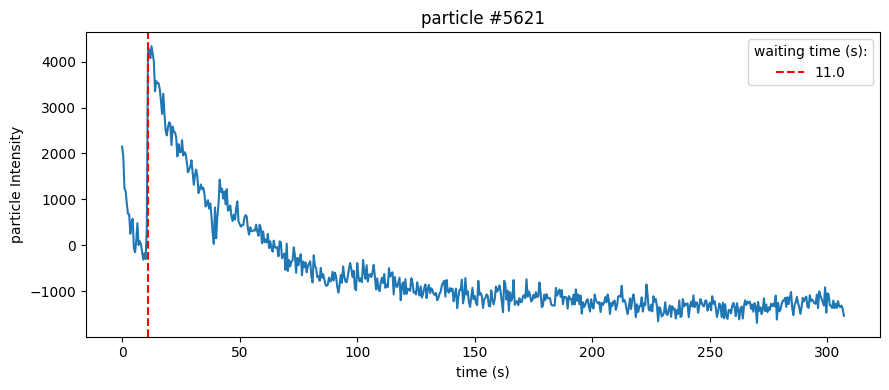

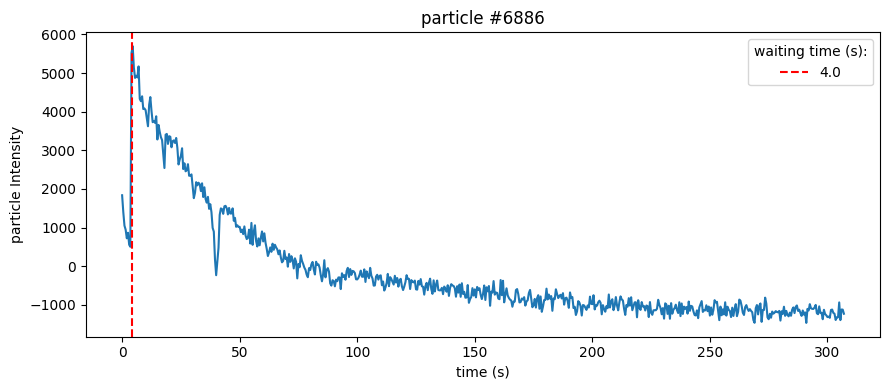

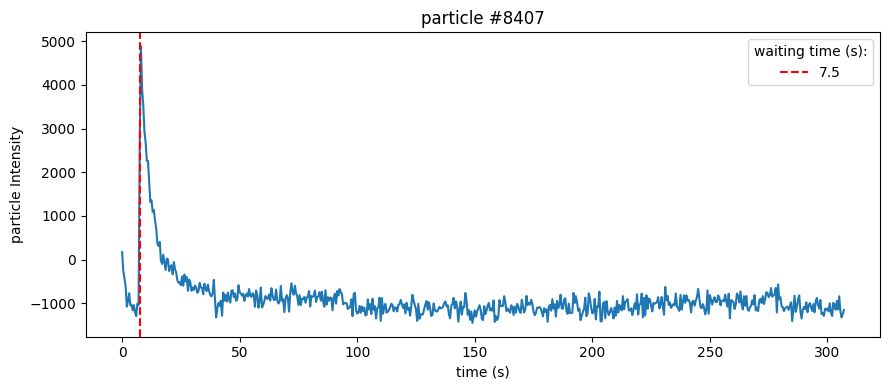

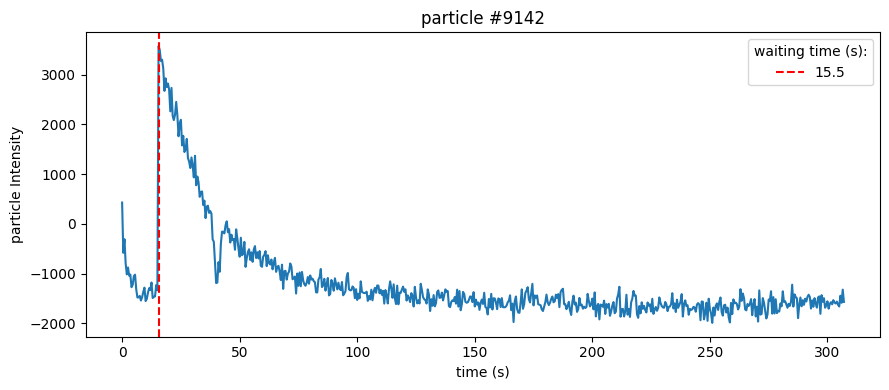

In [29]:
with PdfPages(desktop_path + output_filename + ".pdf") as pdf:
    for key in events:
        if key in df.index:
            row_data = df.loc[key]
            plt.figure(figsize=(9, 4))
            plt.plot(row_data.index, row_data.values)
            plt.title(f'particle #{key}')
            plt.xlabel('time (s)')
            plt.ylabel('particle Intensity')
            # Add vertical dashed lines for each detected event
            for event in events[key]:
                if event in row_data.index:
                    plt.axvline(x=event, color='r', linestyle='--', label=event)
            plt.legend(title="waiting time (s):")
            plt.tight_layout()
            pdf.savefig()
            plt.show()

## _Optional: Fill in a list of particle #'s to either be exclusively kept, or removed from dataset_

In [27]:
particles_of_interest = []

action = "retain"
# "retain" to retain only these particle in the dataset
# "remove" to remove these particle specifically from the dataset

if action == "retain":
    events = {key: value for key, value in events.items() if key in particles_of_interest}
    print("Only particles specified retained in the dataset.")
if action == "remove":
    try:
        for i in particles_of_interest:
            del events[i]
        print("Particles removed successfully.")
    except Exception as e:
        print(f"Error: particle #{e} not found, could not execute.")

Only particles specified retained in the dataset.


## Extract all waiting times and save as a .csv file

In [30]:
# Extract all waiting times from "Events" into a list
waiting_times = [value for sublist in events.values() for value in sublist]
waiting_times.sort()
waiting_times = pd.DataFrame({"waiting_times": waiting_times})
print(waiting_times)

waiting_times.to_csv(desktop_path + output_filename + ".csv", index=False)

    waiting_times
0             1.0
1             2.0
2             2.5
3             4.0
4             4.5
5             7.5
6            11.0
7            14.5
8            15.5
9            25.0
10           48.0
11           63.0
12           76.5
13           99.0
14          113.5
15          270.5
